Построение различных вариантов кластеризаций и интерпретация результатов.
Цель: использовать любой датасет для задачи кластеризации

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('Wholesale customers data.csv', sep = ',')

https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories

1) FRESH: annual spending (m.u.) on fresh products (Continuous);

2) MILK: annual spending (m.u.) on milk products (Continuous);

3) GROCERY: annual spending (m.u.)on grocery products (Continuous);

4) FROZEN: annual spending (m.u.)on frozen products (Continuous)

5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)

6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);

7) CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)

8) REGION: customers Region - Lisnon, Oporto or Other (Nominal)


Dataset includes information about 440 clients total.

In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.shape

(440, 8)

In [5]:
df.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.shape

(440, 8)

In [8]:
# стандартизация данных
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(df.drop(['Channel', 'Region'], axis = 1)) 
  
# нормализация данных
normalized_df = normalize(scaled_df) 
  
# конвертация в pandas DataFrame
normalized_df = pd.DataFrame(normalized_df) 

D:\programs\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\programs\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Попробуем для начала подобрать количество оптимальных кластеров с помощью алгоритма KMeans и оценить оптимальное количество кластеров при помощи метода локтя.

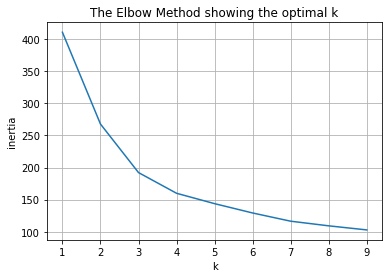

In [9]:
inertia = []
k = range(1, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(normalized_df)
    inertia.append(km.inertia_)
    
plt.plot(k, inertia)
plt.xlabel('k')
plt.grid()
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k');

Теперь попробуем разделить нашу выборку на кластеры при помощи алгоритма иерархической кластеризации. Иерархическая кластеризация отличается от плоской тем, что мы строим не одно разбиение, а целую систему. Т.е. на выходе мы получим иерархию кластеров, которую можем изобразить при помощи дендрограммы.

Plus, in the general case, hierarchical clustering is of complexity O(n^3) which makes it scale really bad to large datasets.

In [10]:
distance_mat = pdist(normalized_df) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'ward') # linkage — реализация агломеративного алгоритма

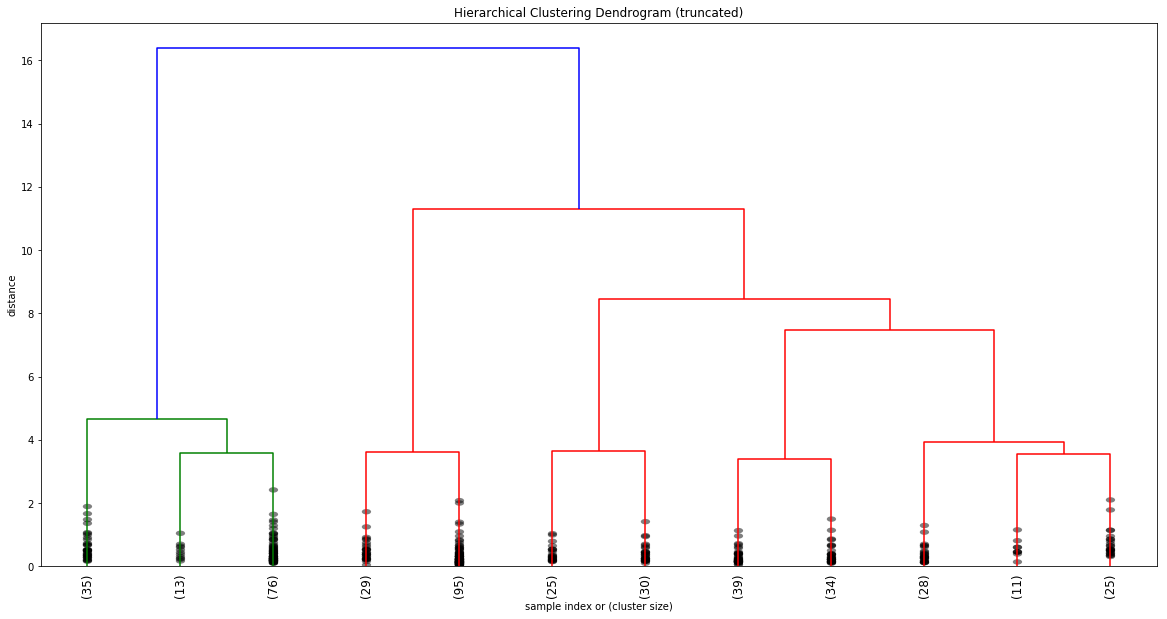

In [11]:
plt.figure(figsize=(20, 10))
# выводим размеры кластеров

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

### DBSCAN

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

Мы можем подсчитать расстояние от каждой точки до её ближайшего соседа использую NearestNeighbors. Сама точка будет включена в n_neighbors. kneighbors метод возвращает два массива, один из которых содержит расстояние до ближайшего соседа точки, а другой содержит индекс для каждой из этих точек. 

In [12]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(normalized_df)
distances, indices = nbrs.kneighbors(normalized_df)

Оптимальное значение для эпсилона - это точка максимальной кривизны.

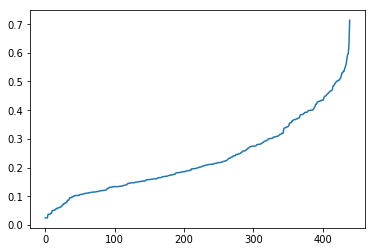

In [13]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Тренировать модель лучше всего на eps = 0.5.

In [14]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples = 5).fit(normalized_df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Estimated percentage of noise points: {:.2f}%'.format(100*n_noise_/normalized_df.shape[0]))

Estimated number of clusters: 2
Estimated percentage of noise points: 9.55%
